In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Math
plt.style.use("ggplot")

2023-01-31 10:03:22.140835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 10:03:22.374512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 10:03:22.374545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 10:03:22.416921: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-31 10:03:23.314462: W tensorflow/stream_executor/platform/de

In [2]:
tfd = tfp.distributions

## Bayesian Approach to Linear Regression
---

One of the most important aspects of the probabilistic approach for linear regression is the ability to incorporate prior information into the model through a Bayesian approach.

We will use the same data samples as in the previous notebook

2023-01-31 10:04:03.853332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-31 10:04:03.853390: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 10:04:03.853425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist
2023-01-31 10:04:03.853986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_18180/967135023.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend

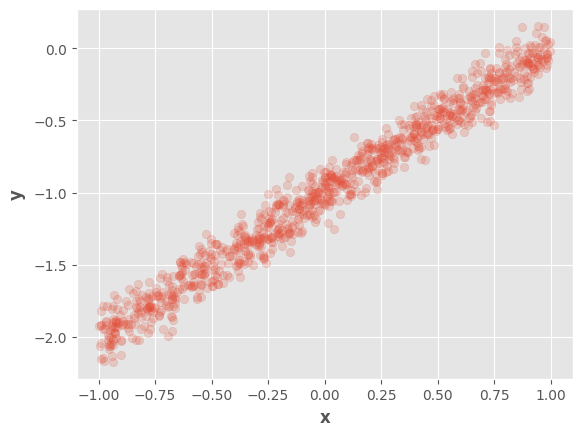

In [4]:
x = tf.random.uniform(
        shape = (1000, 1),
        minval = -1,
        maxval = 1
        )
X = tf.concat([x, tf.ones_like(x)], axis=1)

w_real = tf.constant([[1.0], [-1.0]])
e_real = tf.constant(0.1)

y = X @ w_real + tf.random.normal(shape=(1000, 1), mean=0, stddev=e_real)

fig, ax = plt.subplots()
ax.scatter(tf.squeeze(x), tf.squeeze(y), alpha=0.2)
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_ylabel(r"$\mathbf{y}$")
fig.show()



For instance, we can assume that the model's $\mathbf{w}$ are very likely to be within a circle of radius 3, as shown in the following figure:

/tmp/ipykernel_18180/3600735895.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


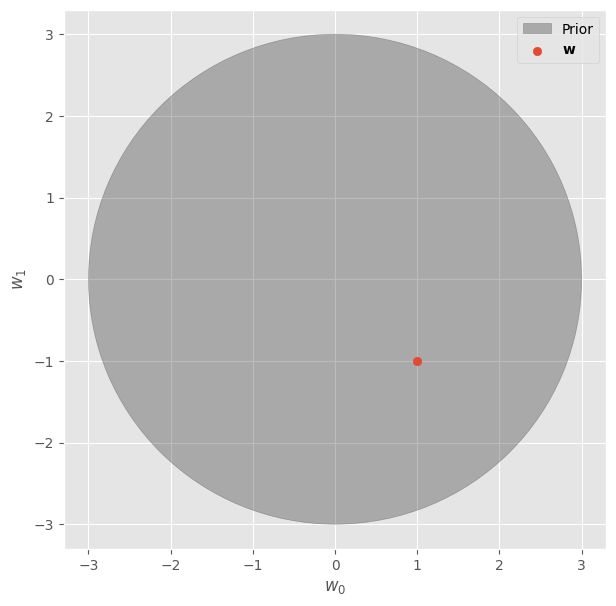

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
circle = plt.Circle((0, 0), 3, color="#33333355", label="Prior")
ax.add_patch(circle)
ax.scatter([w_real[0]], [w_real[1]], label=r"$\mathbf{w}$")
ax.set_xlabel(r"$w_0$")
ax.set_ylabel(r"$w_1$")
ax.legend()
fig.show()

In fact, this is equivalent to the $L_2$ regularization that is typically used in models like Ridge Regression or neural networks. Similarly, this behavior can also be represented through a circular distribution, more precisely:

$$
P(\mathbf{w}) = \mathcal{N}(\mathbf{w} = [0, 0], \Sigma=\mathbf{I})
$$

It is well known that around 96% of the density for this distribution is within a circle with radius 3 and centered at $[0, 0]$. This can be seen in the following figure:

In [6]:
x_range = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x_range, x_range)
X_grid = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
dist = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
probs = dist.prob(X_grid).numpy().reshape(X1.shape)

/tmp/ipykernel_18180/979507797.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(X1, X2, probs, cmap="gray", label=r"$P(\mathbf{w})$")
/tmp/ipykernel_18180/979507797.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


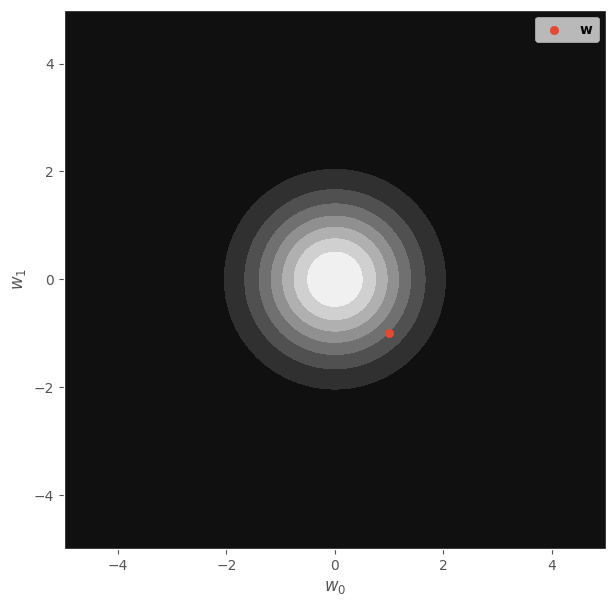

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.contourf(X1, X2, probs, cmap="gray", label=r"$P(\mathbf{w})$")
ax.scatter([w_real[0]], [w_real[1]], label=r"$\mathbf{w}$")
ax.set_xlabel(r"$w_0$")
ax.set_ylabel(r"$w_1$")
ax.legend()
fig.show()

We can use this information as a prior distribution in a Bayesian approach, let's assume that the standard error $E$ is constant, therefore:

$$
\begin{split}
P(\mathbf{w}) = \mathcal{N}(\mathbf{w}=[0, 0], \Sigma=\mathbf{I}) \\
P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) = \mathcal{N}(\mathbf{y} = \mathbf{X} \cdot \mathbf{w}, \sigma=E)
\end{split}
$$

Using the Bayes rule, we obtain:

$$
P(\mathbf{w} | \mathbf{X}, \mathbf{y}, E) = \frac{P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) P(\mathbf{w})}{P(\mathbf{X}, \mathbf{y}, E)}
$$

## Maximum Aposteriori Estimation
---

The maximum aposteriori estimation (MAP) is similar to maximum likelihood estimation (MLE), however, in this case we perform the following optimization:

$$
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left( P(\mathbf{w} | \mathbf{X}, \mathbf{y}, E) \right)
$$

Which is equivalent of the optimiziation of the log-posterior considering the convexity of the log function:

$$
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left(\log{P(\mathbf{w} | \mathbf{X}, \mathbf{y}, E)}\right)
$$

We can use the Bayes rule:

$$
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left( \log{P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) } + \log{P(\mathbf{w})} - \log{P(\mathbf{X}, \mathbf{y}, E)} \right)
$$

However, the term $\log{P(\mathbf{X}, \mathbf{y}, E)}$ does not depend on $\mathbf{w}$ and the optimization can be simplified to:

$$
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left( \log{P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E)} + \log{P(\mathbf{w})} \right)
$$

### Closed-form Solution
---

We can obtain an analytical solution in some cases, for example, when both the prior and the posterior are normal.

Let's see that case:

$$
\begin{split}
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left( \log{P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E)} + \log{P(\mathbf{w})} \right)\\
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} \left( \log{\mathcal{N} (y = \mathbf{X} \cdot \mathbf{w}, \sigma=E)} + \log{\mathcal{N}(\mathbf{w} = [0, 0], \sigma=\tau)}\right)\\
\mathbf{w_{map}} = \underset{\mathbf{w}}{\text{argmax}} - \frac{1}{E} (y - \mathbf{X} \cdot \mathbf{w}) ^ 2 - \frac{1}{2\tau ^ 2}||\mathbf{w}|| ^ 2
\end{split}
$$

As you can see, this is equivalent to the optimization of the mean squared error:

$$
\mathcal{L} = (y - \mathbf{X} \cdot \mathbf{w}) ^ 2
$$

Using a regularization term:

$$
\mathcal{R} = ||\mathbf{w}|| ^ 2
$$

And a regularization constant:

$$
\lambda = \frac{1}{2 \tau ^ 2}
$$

We can find a closed-form solution using the derivative:

$$
\frac{\partial}{\partial \mathbf{w}} (\mathcal{L} + \lambda \mathcal{R}) = 0
$$

Which leads to the solution of a Ridge regression model:

$$
\mathbf{w_{map}} = (\mathbf{X} ^ T \cdot \mathbf{X} + \lambda \mathbf{I}) ^ {-1} \mathbf{X} ^ T \mathbf{y}
$$

Let's see this in `tensorflow`:

In [8]:
l = 0.5
w_map = (
        tf.linalg.pinv(tf.transpose(X) @ X + l * tf.eye(X.shape[1])) @
        tf.transpose(X) @ y
        )
display(w_map)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.0055537],
       [-1.0020475]], dtype=float32)>

### Optimization
---

In a more general scenario the distributions may not be normal. However, We can find a MAP estimation using automatic differentiation and `tensorflow_probability`.

Let's see an example with the following likelihood and prior distributions:

$$
\begin{split}
P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) = N(\mathbf{y} = \mathbf{X} \cdot \mathbf{w}, \sigma=E)\\
P(\mathbf{w}) = \text{Laplace}(\mathbf{w} = [0, 0], \Sigma=\mathbf{I})
\end{split}
$$

We can define this model as a joint distribution:

In [10]:
model = tfd.JointDistributionNamedAutoBatched({
    "w": tfd.Independent(tfd.Laplace(loc=[0, 0], scale=1), reinterpreted_batch_ndims=1),
    "y": lambda w: tfd.Normal(loc=X @ tf.reshape(w, (-1, 1)), scale=e_real)
    })

And We can find the MAP estimation through a training loop:

In [11]:
n_iters = 100
w = tf.Variable([0.0, 0.0])
l = 0.5
optimizer = Adam(learning_rate=1e-2)
training_variables = [w]
for i in range(n_iters):
    with tf.GradientTape() as t:
        model = tfd.JointDistributionNamedAutoBatched({
            "w": tfd.Independent(
                tfd.Laplace(loc=[0, 0], scale=l),
                reinterpreted_batch_ndims=1,
            ),
            "y": lambda w: tfd.Normal(loc=X @ tf.reshape(w, (-1, 1)), scale=e_real)
            })
        nll = -tf.reduce_sum(model.log_prob(w = w, y = y))
        grads = t.gradient(nll, training_variables)
        optimizer.apply_gradients(zip(grads, training_variables))

Let's see $\mathbf{w_{map}}$ estimation:

In [12]:
display(Math(r"\mathbf{w}"))
display(w_real)
display(Math(r"\mathbf{w_{map}}"))
display(w)

<IPython.core.display.Math object>

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.],
       [-1.]], dtype=float32)>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.77465045, -0.7760587 ], dtype=float32)>

As you can see, the weights are lower in comparison to the real ones, which is a result of the regularization.

With this approach, it's possible to optimize the standard error too:

In [13]:
n_iters = 100
w = tf.Variable([0.0, 0.0])
e = tf.Variable(1.0)
l = 0.1
optimizer = Adam(learning_rate=1e-2)
training_variables = [w, e]
for i in range(n_iters):
    with tf.GradientTape() as t:
        model = tfd.JointDistributionNamedAutoBatched({
            "w": tfd.Independent(
                tfd.Laplace(loc=[0, 0], scale=l),
                reinterpreted_batch_ndims=1,
            ),
            "y": lambda w: tfd.Normal(loc=X @ tf.reshape(w, (-1, 1)), scale=e)
            })
        nll = -tf.reduce_sum(model.log_prob(w = w, y = y))
        grads = t.gradient(nll, training_variables)
        optimizer.apply_gradients(zip(grads, training_variables))

We find the following results:

In [14]:
display(Math(r"\mathbf{w}"))
display(w_real)
display(Math(r"\mathbf{w_{map}}"))
display(w)

<IPython.core.display.Math object>

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.],
       [-1.]], dtype=float32)>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.99559814, -1.00392   ], dtype=float32)>

In [15]:
display(Math(r"E"))
display(e_real)
display(Math(r"\tilde{E}"))
display(e)

<IPython.core.display.Math object>

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1326189>

Let's visualize the results:

In [16]:
x_test = tf.cast(
        tf.reshape(tf.linspace(start=-1, stop=1, num=100), (-1, 1)),
        tf.float32
        )
X_test = tf.concat([x_test, tf.ones_like(x_test)], axis=1)
y_pred = X_test @ tf.reshape(w, (-1, 1))
y_pred_high = y_pred + 3 * tf.ones_like(y_pred) * e
y_pred_low = y_pred - 3 * tf.ones_like(y_pred) * e

/tmp/ipykernel_18180/2646422756.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


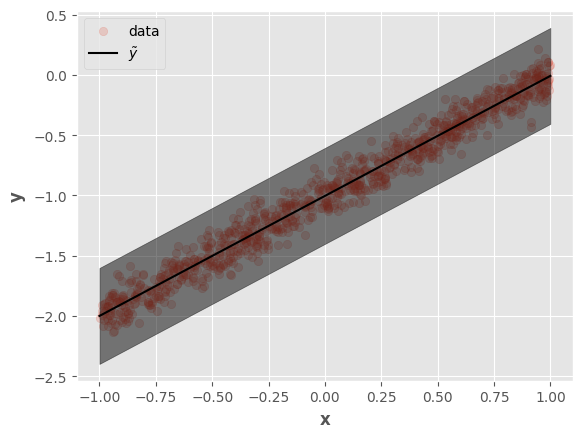

In [17]:
fig, ax = plt.subplots()
ax.scatter(tf.squeeze(x), tf.squeeze(y), alpha=0.2, label="data")
ax.plot(tf.squeeze(x_test), tf.squeeze(y_pred), label=r"$\tilde{y}$", color="k")
ax.fill_between(
    tf.squeeze(x_test),
    tf.squeeze(y_pred_low),
    tf.squeeze(y_pred_high),
    alpha=0.5, color="k"
)
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_ylabel(r"$\mathbf{y}$")
ax.legend()
fig.show()

This result is equivalent to the Lasso regression model, which uses $L_1$ regularization (equivalent to the Laplace distribution). Nevertheless, it's possible to optimize any model by changing the distributions.

## Sampling From the Posterior
---

Up to this point, We've seen how to obtain the most likely parameters according to the posterior distribution (MAP estimation), however, it would be dessirable to have the posterior distribution or at least some samples from it.

This can be achieved through Markov Chain Monte Carlo (MCMC), to this end, let us define the following model:

$$
\begin{split}
P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) = N(\mathbf{y} = \mathbf{X} \cdot \mathbf{w}, \sigma = E)\\
P(\mathbf{w}) = N(\mathbf{w} = [0, 0], \Sigma = \mathbf{I})
\end{split}
$$

In [18]:
model = tfd.JointDistributionNamedAutoBatched({
    "w": tfd.Normal(loc=tf.zeros(shape=(2, 1)), scale=4.0),
    "y": lambda w: tfd.Normal(loc=X @ w, scale=e_real)
    })

We can define the log function to optimize from this model:

In [19]:
def log_prob(w):
    return model.log_prob(w=w, y=y)

Also, let us define the MCMC procedure as a `tensorflow` function:

In [20]:
@tf.function
def mcmc():
    kernel = tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn = log_prob,
            step_size=1e-3
            )
    return tfp.mcmc.sample_chain(
            num_results = 1000,
            num_burnin_steps = 500,
            current_state = [tf.zeros(shape=(2, 1))],
            kernel = kernel,
            trace_fn = lambda _, results: results.target_log_prob
            )

Now, we can compute samples from the posterior distribution $P(\mathbf{w}|\mathbf{y}, \mathbf{X}, E)$:

In [21]:
samples, log_probs = mcmc()
w_posterior = tf.squeeze(samples[0])

We can visualize these distributions:

/tmp/ipykernel_18180/2796555064.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


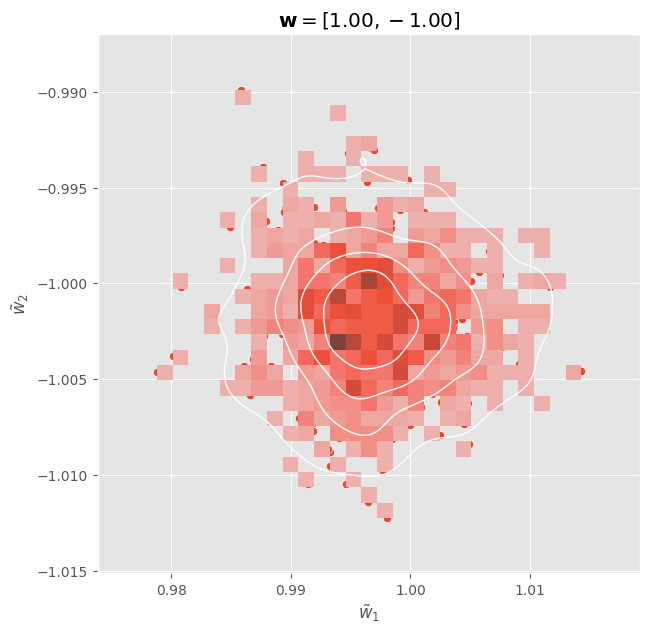

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x = w_posterior[:, 0], y = w_posterior[:, 1], ax = ax)
sns.histplot(x = w_posterior[:, 0], y = w_posterior[:, 1], ax = ax)
sns.kdeplot(
    x = w_posterior[:, 0],
    y = w_posterior[:, 1],
    levels=5,
    color="w", linewidths=1,
    ax = ax
)
ax.set_xlabel(r"$\tilde{w}_1$")
ax.set_ylabel(r"$\tilde{w}_2$")
ax.set_title(r"$\mathbf{w} = " + f"[{w_real[0, 0]:.2f}, {w_real[1, 0]:.2f}]$")
fig.show()